# 63 Displaying Well Log along Well Path

This notebook illustrates how to illustrates how to display a well log consisting of measured depth values and the actual measured values along a well path defined by a well path consisting of x, y, and z coordinates. 

<img src="../images/tutorial63_cover.png">

## Set File Paths and download Tutorial Data

If you downloaded the latest `GemGIS` version from the Github repository, append the path so that the package can be imported successfully. Otherwise, it is recommended to install `GemGIS` via `pip install gemgis` and import `GemGIS` using `import gemgis as gg`. In addition, the file path to the folder where the data is being stored is set. The tutorial data is downloaded using Pooch (https://www.fatiando.org/pooch/latest/index.html) and stored in the specified folder. Use `pip install pooch` if Pooch is not installed on your system yet.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pyvista as pv
import pandas as pd
from typing import Union

# Defining well and well log values

First, we define an arbitrary well path using three points as NumPy Array. The measured depths (`dist`) and and some random values are defined as 1D NumPy arrays. 

In [3]:
coordinates = np.array([[0,0,0],
                       [0, 0, -500],
                       [-200, 300,-800]])
pd.DataFrame(coordinates, columns=['X', 'Y', 'Z'])

,X,Y,Z
0,0,0,0
1,0,0,-500
2,-200,300,-800


In [6]:
dist = np.arange(0,901,1)
values = np.random.random(901)

In [7]:
df = pd.DataFrame(dist, columns=['MD'])
df['values'] = values
df

,MD,values
0,0,0.902572
1,1,0.727718
2,2,0.769483
3,3,0.064950
4,4,0.950260
...,...,...
896,896,0.416416
897,897,0.417463
898,898,0.848264
899,899,0.881004


# Interpolate/Resample between points

The second step is to resample linearly between each provided well path point. A spacing of 5 cm between each point is chosen by default. 

In [8]:
points = gg.visualization.resample_between_well_deviation_points(coordinates)
pd.DataFrame(points, columns=['X', 'Y', 'Z'])

,X,Y,Z
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,-0.050005
2,0.000000,0.000000,-0.100010
3,0.000000,0.000000,-0.150015
4,0.000000,0.000000,-0.200020
...,...,...,...
19376,-199.914712,299.872068,-799.872068
19377,-199.936034,299.904051,-799.904051
19378,-199.957356,299.936034,-799.936034
19379,-199.978678,299.968017,-799.968017


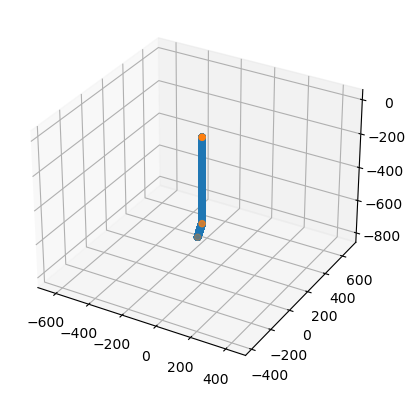

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2])
ax.scatter(coordinates[:,0], coordinates[:,1], coordinates[:,2])
ax.set_aspect('equal')
ax.grid()

# Create Polyline from well path coordinates

Then, we create a polyline of the original well path for visualization purposes. 

In [11]:
polyline_well_path = gg.visualization.polyline_from_points(coordinates)
polyline_well_path

PolyData,Information
N Cells,1
N Points,3
N Strips,0
X Bounds,"-2.000e+02, 0.000e+00"
Y Bounds,"0.000e+00, 3.000e+02"
Z Bounds,"-8.000e+02, 0.000e+00"
N Arrays,0


# Creating Spline from resampled well path coordinates

Now, we are creating spline of the resampled points. This automatically calculates the `arc_length` which will be utilized in the next step. 

In [12]:
polyline_well_path_resampled = pv.Spline(points)
polyline_well_path_resampled

PolyData (0x298a7c077c0)
  N Cells:    1
  N Points:   19381
  N Strips:   0
  X Bounds:   -2.000e+02, 1.520e-03
  Y Bounds:   -2.280e-03, 3.000e+02
  Z Bounds:   -8.000e+02, 0.000e+00
  N Arrays:   1

# Getting the Points along the resampled Spline

The main step is to assign a resampled value to a measured value using `get_points_along_spline`. 

In [13]:
points_along_spline = gg.visualization.get_points_along_spline(polyline_well_path_resampled, dist)
pd.DataFrame(points_along_spline, columns=['X', 'Y', 'Z'])

,X,Y,Z
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,-1.000043
2,0.000000,0.000000,-2.000086
3,0.000000,0.000000,-3.000129
4,0.000000,0.000000,-4.000172
...,...,...,...
896,-168.850037,253.275055,-753.275085
897,-169.276459,253.914688,-753.914673
898,-169.702881,254.554321,-754.554321
899,-170.129303,255.193954,-755.193970


# Creating Polyline from Points, assigning values and creating Tube

Once we have extracted the points, we again create a PolyLine from it. We then assign the measured well log values as data array to the newly created PolyLine and create a tube from it using the `values` to define the radius of the tube. The `radius_factor` is a scaling factor that needs to changed according to the length of the well. 

In [14]:
polyline_along_spline = gg.visualization.polyline_from_points(points_along_spline)
polyline_along_spline['values'] = values
tube_along_spline = polyline_along_spline.tube(scalars='values', radius_factor=75)
tube_along_spline

PolyData (0x298a8c46e80)
  N Cells:    22
  N Points:   18060
  N Strips:   22
  X Bounds:   -2.000e+02, 3.747e+01
  Y Bounds:   -3.747e+01, 2.805e+02
  Z Bounds:   -7.807e+02, 0.000e+00
  N Arrays:   2

# Combined Function

In [23]:
tube_along_spline = show_well_log_along_well(coordinates, dist, values, radius_factor=75)
tube_along_spline

PolyData (0x298a9080fa0)
  N Cells:    22
  N Points:   18060
  N Strips:   22
  X Bounds:   -2.000e+02, 3.747e+01
  Y Bounds:   -3.747e+01, 2.805e+02
  Z Bounds:   -7.807e+02, 0.000e+00
  N Arrays:   2

# Plotting the result

C:\Users\ale93371\Anaconda3\envs\gempy_new8\lib\site-packages\pyvista\utilities\helpers.py:507: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(
C:\Users\ale93371\Anaconda3\envs\gempy_new8\lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


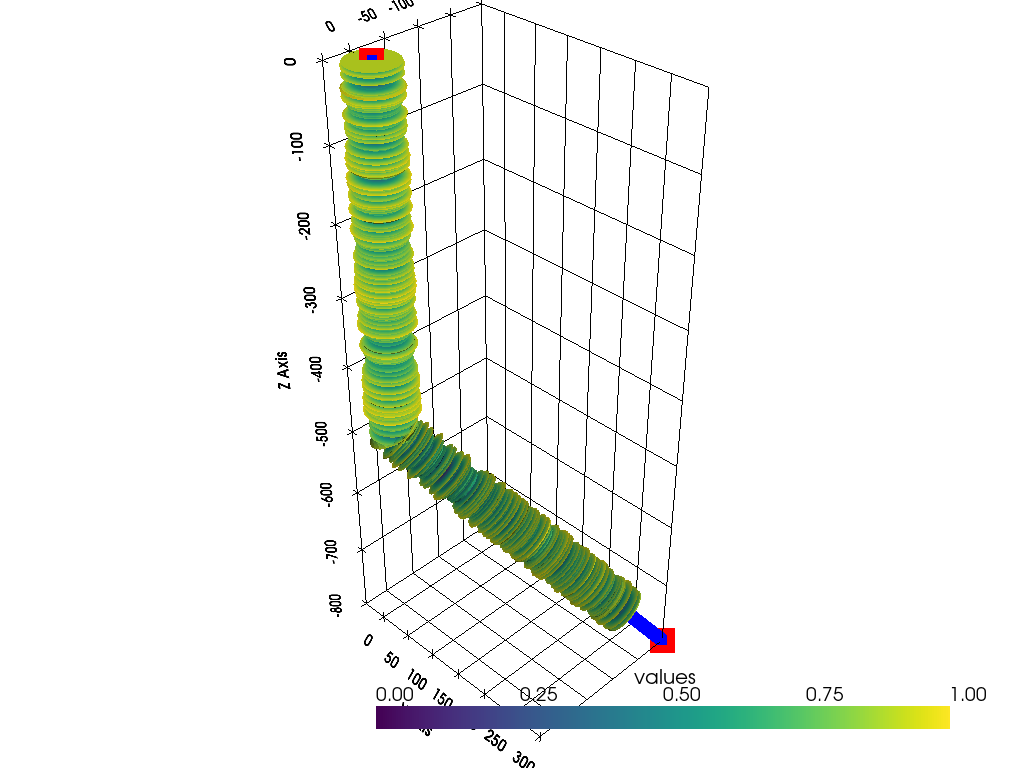

In [24]:
sargs = dict(fmt="%.2f", color='black')

p = pv.Plotter(notebook=True)

p.add_mesh(tube_along_spline, scalar_bar_args=sargs, clim=[0,1])
p.add_mesh(pv.PolyData(coordinates), color='red', point_size=25)
p.add_mesh(pv.PolyData(points), color='blue', point_size=10)

p.set_background('white')
p.show_grid(color='black')
p.show()